# Semi-supervised surgery pipeline with SCANVI

In [1]:
try:
    from nbproject import header
    header()
except ModuleNotFoundError:
    print("If you want to see the header with dependencies, please install nbproject - pip install nbproject")

If you want to see the header with dependencies, please install nbproject - pip install nbproject


In [2]:
import scvi
scvi.__version__

Global seed set to 0


'0.15.0'

In [3]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [5]:
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

 captum (see https://github.com/pytorch/captum).


In [7]:
sca

<module 'scarches' from '/lustre/groups/ml01/workspace/ignacio.ibarra/theislab/scarches/scarches/__init__.py'>

In [8]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas.

In [75]:
condition_key = 'study'
condition_key = 'batch_donor_dataset'
cell_type_key = 'cell_type'
target_conditions = ['nan:Roska:4',]
# target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']

### Download Dataset and split into reference dataset and query dataset

In [10]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd
To: /lustre/groups/ml01/workspace/ignacio.ibarra/theislab/scarches/pancreas.h5ad
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126M/126M [00:01<00:00, 102MB/s]


'pancreas.h5ad'

In [56]:
# adata_all = sc.read('pancreas.h5ad')
adata_all = sc.read_h5ad('../mapping_data_to_sc_atlas/data/RCA/scvi_E100_L2_H256.h5ad')

In [57]:
adata = adata_all # .raw.to_adata()
# adata_all.raw
adata.X = adata.layers['counts']
print(adata.shape)
adata = remove_sparsity(adata)
print(adata.shape)


adata.obs[cell_type_key] = adata.obs['cell.type']

(85560, 3000)
(85560, 3000)


In [59]:
adata.X.max()

4830.0

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss.

In [141]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions), target_var_names].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions), target_var_names].copy()

In [142]:
source_adata.shape, target_adata.shape

((85061, 2579), (499, 2579))

### Create SCANVI model and train it on fully labelled reference dataset

Preprocess reference dataset. Remember that the adata file has to have count data in adata.X for SCVI/SCANVI if not further specified

In [143]:
sca.models.SCVI.setup_anndata(source_adata, batch_key=condition_key, labels_key=cell_type_key)

# this only works in newer version
# sca.dataset.setup_anndata(source_adata, batch_key=condition_key, labels_key=cell_type_key)

In [144]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
    
)

In [145]:
vae.train(max_epochs=3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 3/3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.04s/it, loss=1.57e+03, v_num=1]


Create the SCANVI model instance with ZINB loss as default. Insert "gene_likelihood='nb'," to change the reconstruction loss to NB loss.

In [146]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

In [147]:
print("Labelled Indices: ", len(scanvae._labeled_indices))
print("Unlabelled Indices: ", len(scanvae._unlabeled_indices))

Labelled Indices:  0
Unlabelled Indices:  0


In [148]:
scanvae.train(max_epochs=3)

INFO     Training for 3 epochs.                                                                                    


INFO:scvi.model._scanvi:Training for 3 epochs.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 3/3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:40<00:00, 33.44s/it, loss=1.62e+03, v_num=1]


### Create anndata file of latent representation and compute UMAP

In [149]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

In [150]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)

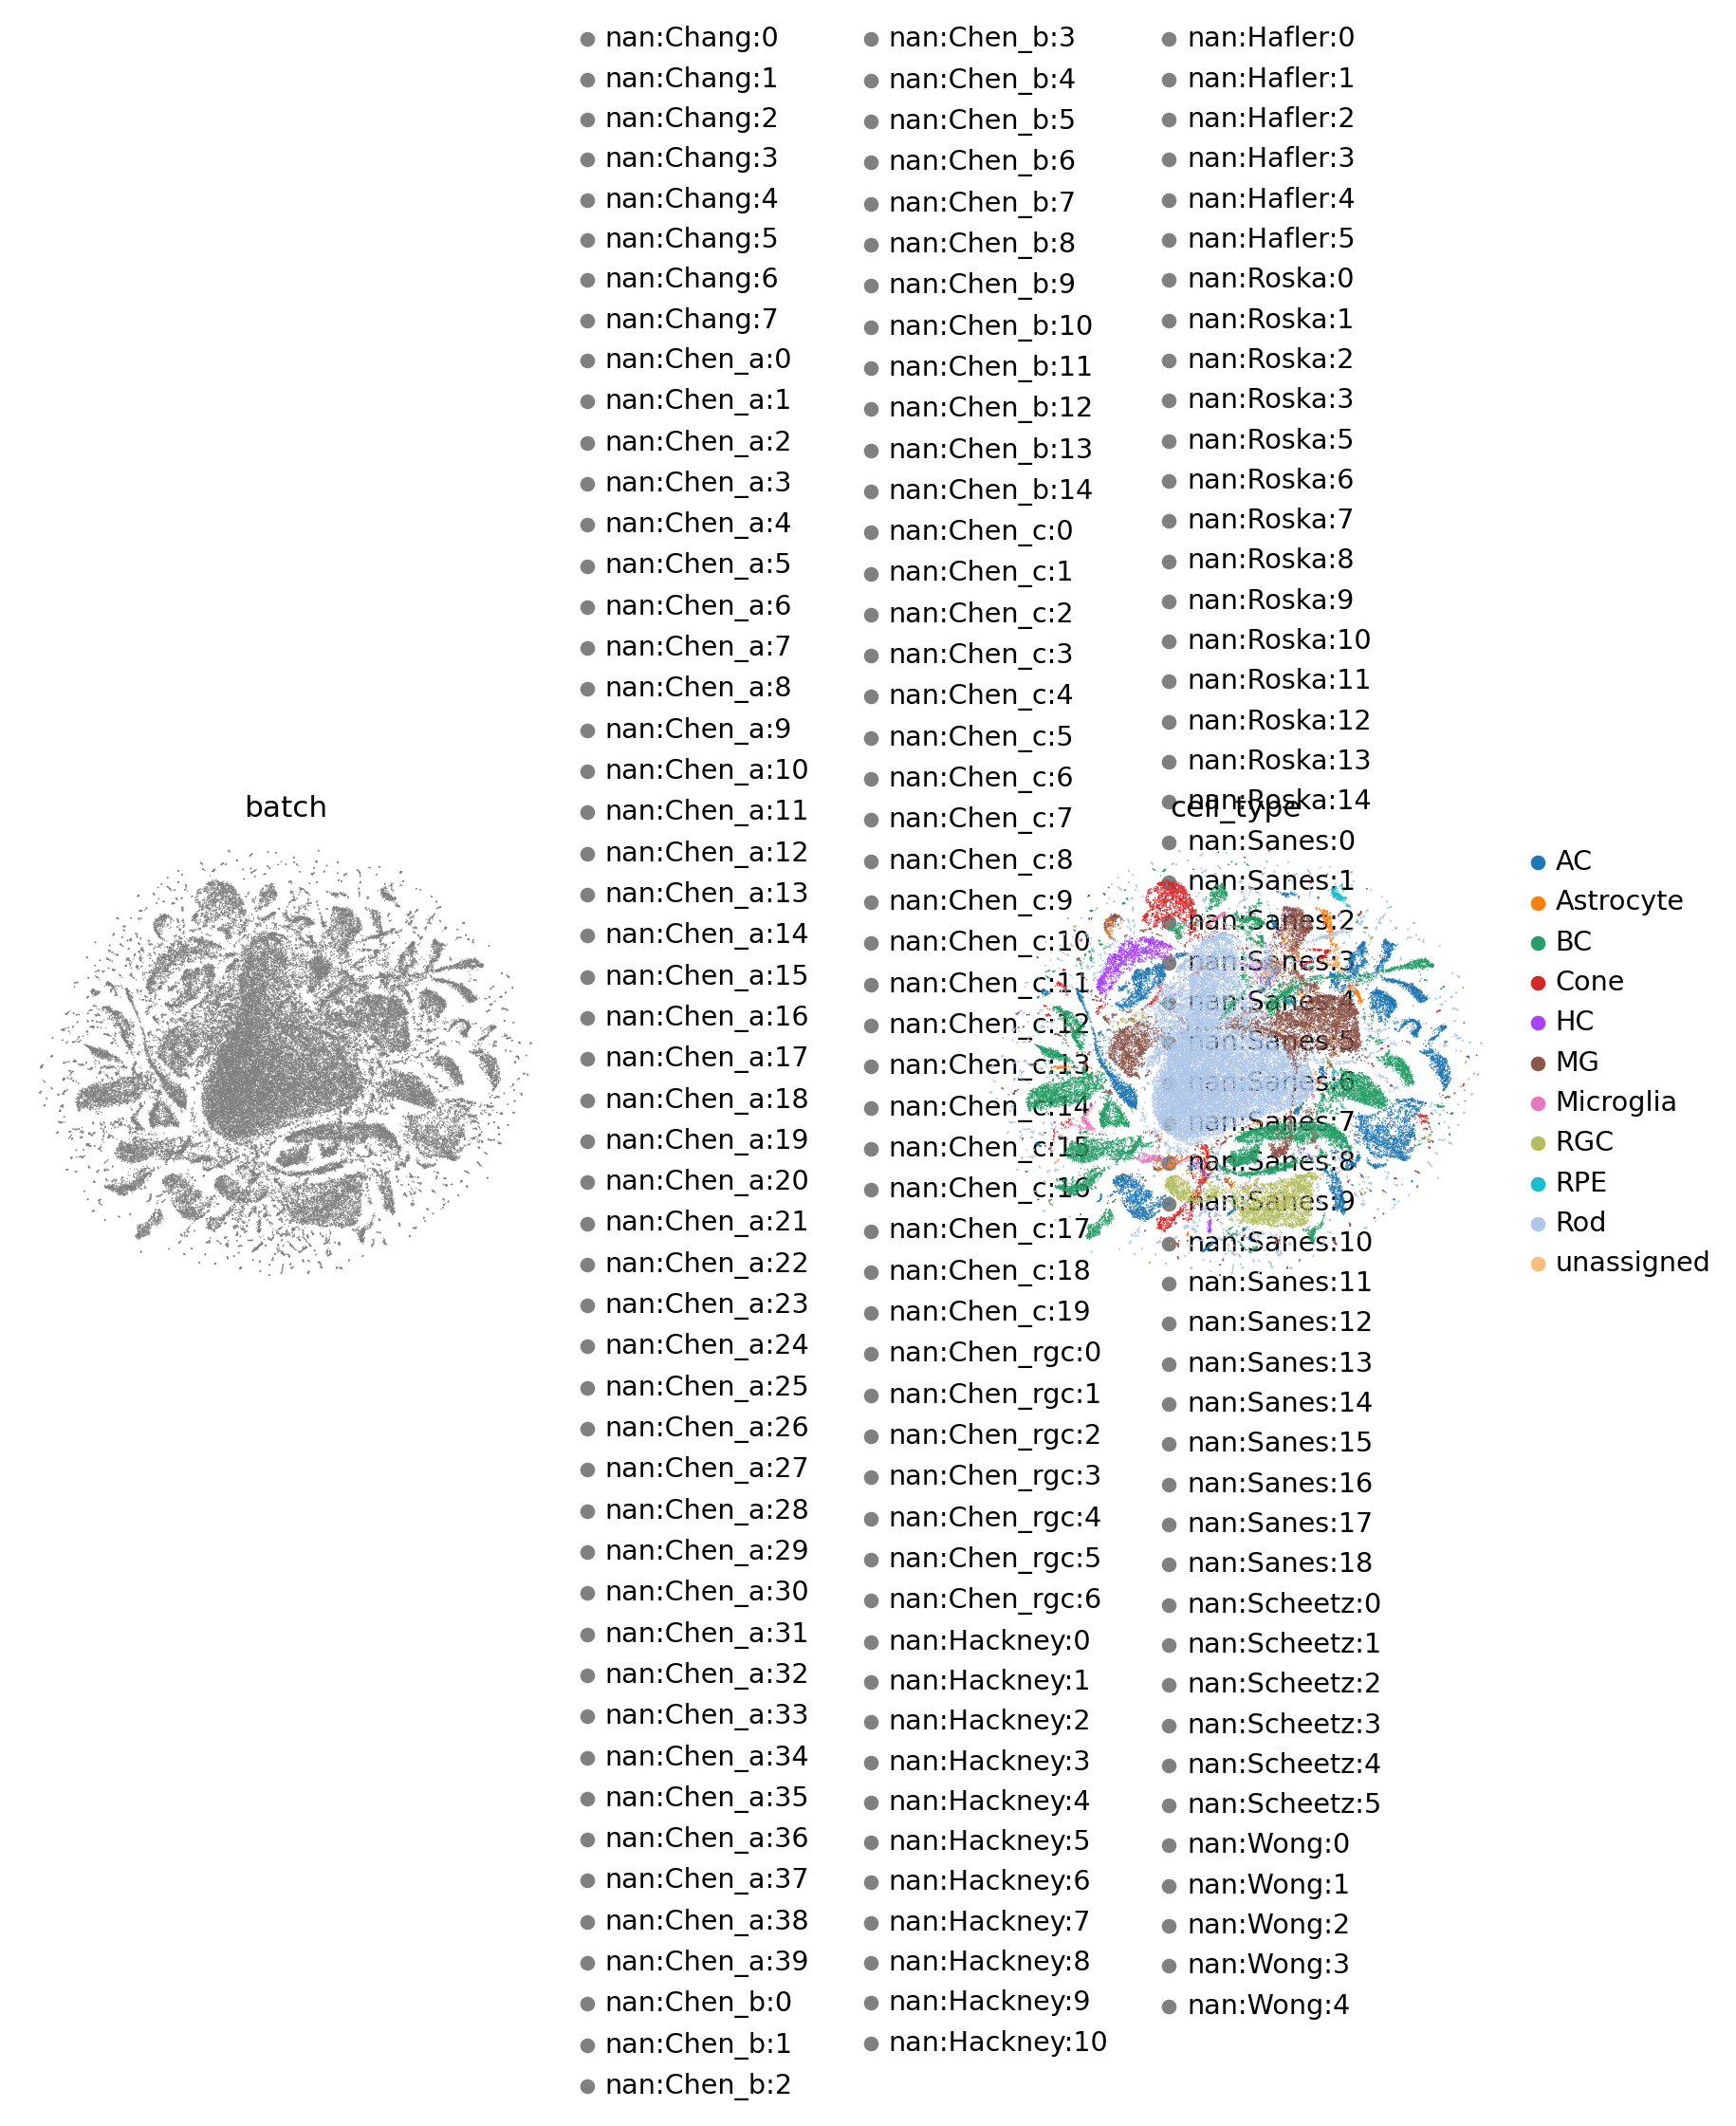

In [151]:

sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

One can also compute the accuracy of the learned classifier

In [152]:
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.9675644537449595


After pretraining the model can be saved for later use

In [153]:
ref_path = 'ref_model/'
scanvae.save(ref_path, overwrite=True)

### Perform surgery on reference model and train on query dataset without cell type labels

If the cell types in 'target_adata' are equal to or a subset of the reference data cell types, one can just pass the adata without further preprocessing. It is also possible then to do semi-supervised training with scArches.

However if there are new cell types in 'target_adata' or if there is no '.obs' in the anndata for cell type labels (e.g. the data is unlabeled), one can only use scANVI in an unsupervised manner during surgery due to the nature of the classifier. 

In addition one has to preprocess 'target_adata' in the following way:

If there are new celltypes in there, save the original labels in other column and replace all labels with unlabeled category:

In [154]:
# load retina data
path_to_AMD = '/lustre/groups/ml01/datasets/projects/20210318_retinal_data_integration_ignacio.ibarra_malte.luecken/20221611_redownload/chen_rna_atlas/application/AMD/legacy_AMD_hg19'
import os
target_adata = sc.read_h5ad(os.path.join(path_to_AMD, 'AMD_RNA_0.9.h5ad'))

In [213]:
target_adata.obs

sampleid majorclass cell_type
AAACCCAAGAATCCCT-1_4     AMD1        Rod   Unknown
AAACCCAAGTTCCATG-1_4     AMD1        Rod   Unknown
AAACCCACAACTCCAA-1_4     AMD1        Rod   Unknown
AAACCCACACAACCGC-1_4     AMD1        Rod   Unknown
AAACCCACAGGGCTTC-1_4     AMD1         BC   Unknown
...                       ...        ...       ...
TTTGTTGCAACCAATC-1_5     AMD2        Rod   Unknown
TTTGTTGGTAGGAGTC-1_5     AMD2        Rod   Unknown
TTTGTTGGTGGATACG-1_5     AMD2        Rod   Unknown
TTTGTTGTCCTGCCAT-1_5     AMD2        Rod   Unknown
TTTGTTGTCCTTCTTC-1_5     AMD2         BC   Unknown

[22405 rows x 3 columns]

In [159]:
# target_adata.obs['orig_cell_types'] = target_adata.obs['majorclass'].copy()
# del target_adata.obs['majorclass']
# target_adata.obs[cell_type_key] = scanvae.unlabeled_category_

If there is no '.obs' column for cell types:

In [156]:
target_adata.obs[cell_type_key] = scanvae.unlabeled_category_

If 'target_adata' is in the right format, one can proceed with the surgery pipeline. Here we do the surgery unsupervised, but due to the overlapping cell types in query and reference data, one could also do supervised or semi-supervised surgery by setting the indices accordingly.

In [214]:
source_adata.var

highly_variable     means  dispersions  dispersions_norm  \
GRIK1                  True  0.377877     2.564088         22.184351   
ZNF804B                True  0.307930     1.898118         14.454078   
NTNG1                  True  0.229666     1.613199         11.329683   
KIAA1217               True  0.528229     1.694644         11.196862   
NETO1                  True  0.337236     1.677122         11.118122   
...                     ...       ...          ...               ...   
RNF2                   True  0.077956     0.830253          0.238415   
KANSL1-AS1             True  0.016577     0.816446          0.234756   
FAIM2                  True  0.175954     0.814786          0.234509   
ARHGEF2                True  0.051868     0.834338          0.228164   
ZNF467                 True  0.060679     0.826490          0.201343   

            highly_variable_nbatches  highly_variable_intersection  
GRIK1                            152                          True  
ZNF804B                          152                          True  
NTNG1                            152                          True  
KIAA1217                         152                          True  
NETO1                            152                          True  
...                              ...                           ...  
RNF2                              50                         False  
KANSL1-AS1                        50                         False  
FAIM2                             50                         False  
ARHGEF2                           50                         False  
ZNF467                            50                         False  

[2579 rows x 6 columns]

In [157]:
target_var_names = source_adata.var_names[source_adata.var_names.isin(target_adata.var_names)]
target_adata_sub = target_adata[:,target_var_names].copy()
target_adata.shape, target_adata_sub.shape

((22405, 32738), (22405, 2579))

In [162]:
target_adata_sub.obs['batch_donor_dataset'] = 'AMD'

In [163]:
model = sca.models.SCANVI.load_query_data(
    target_adata_sub,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata_sub.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

Labelled Indices:  0
Unlabelled Indices:  22405


In [193]:
model.train(
    max_epochs=25, # 100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 25 epochs.                                                                                   


INFO:scvi.model._scanvi:Training for 25 epochs.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 25/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:12<00:00,  5.30s/it, loss=1.44e+03, v_num=1]


In [194]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata_sub.obs[cell_type_key].tolist()
query_latent.obs['batch'] = target_adata_sub.obs[condition_key].tolist()


In [195]:
query_latent.obs['majorclass'] = target_adata_sub.obs['majorclass'].tolist()

In [196]:
print('neighbors')
sc.pp.neighbors(query_latent)
print('leiden')
sc.tl.leiden(query_latent)
print('umap')
sc.tl.umap(query_latent)

neighbors
leiden
umap


In [197]:
target_adata_sub.obs

sampleid majorclass cell_type batch_donor_dataset  \
AAACCCAAGAATCCCT-1_4     AMD1        Rod   Unknown                 AMD   
AAACCCAAGTTCCATG-1_4     AMD1        Rod   Unknown                 AMD   
AAACCCACAACTCCAA-1_4     AMD1        Rod   Unknown                 AMD   
AAACCCACACAACCGC-1_4     AMD1        Rod   Unknown                 AMD   
AAACCCACAGGGCTTC-1_4     AMD1         BC   Unknown                 AMD   
...                       ...        ...       ...                 ...   
TTTGTTGCAACCAATC-1_5     AMD2        Rod   Unknown                 AMD   
TTTGTTGGTAGGAGTC-1_5     AMD2        Rod   Unknown                 AMD   
TTTGTTGGTGGATACG-1_5     AMD2        Rod   Unknown                 AMD   
TTTGTTGTCCTGCCAT-1_5     AMD2        Rod   Unknown                 AMD   
TTTGTTGTCCTTCTTC-1_5     AMD2         BC   Unknown                 AMD   

                      _scvi_batch  _scvi_labels  
AAACCCAAGAATCCCT-1_4          151            11  
AAACCCAAGTTCCATG-1_4          151            11  
AAACCCACAACTCCAA-1_4          151            11  
AAACCCACACAACCGC-1_4          151            11  
AAACCCACAGGGCTTC-1_4          151            11  
...                           ...           ...  
TTTGTTGCAACCAATC-1_5          151            11  
TTTGTTGGTAGGAGTC-1_5          151            11  
TTTGTTGGTGGATACG-1_5          151            11  
TTTGTTGTCCTGCCAT-1_5          151            11  
TTTGTTGTCCTTCTTC-1_5          151            11  

[22405 rows x 6 columns]

<Figure size 320x320 with 0 Axes>

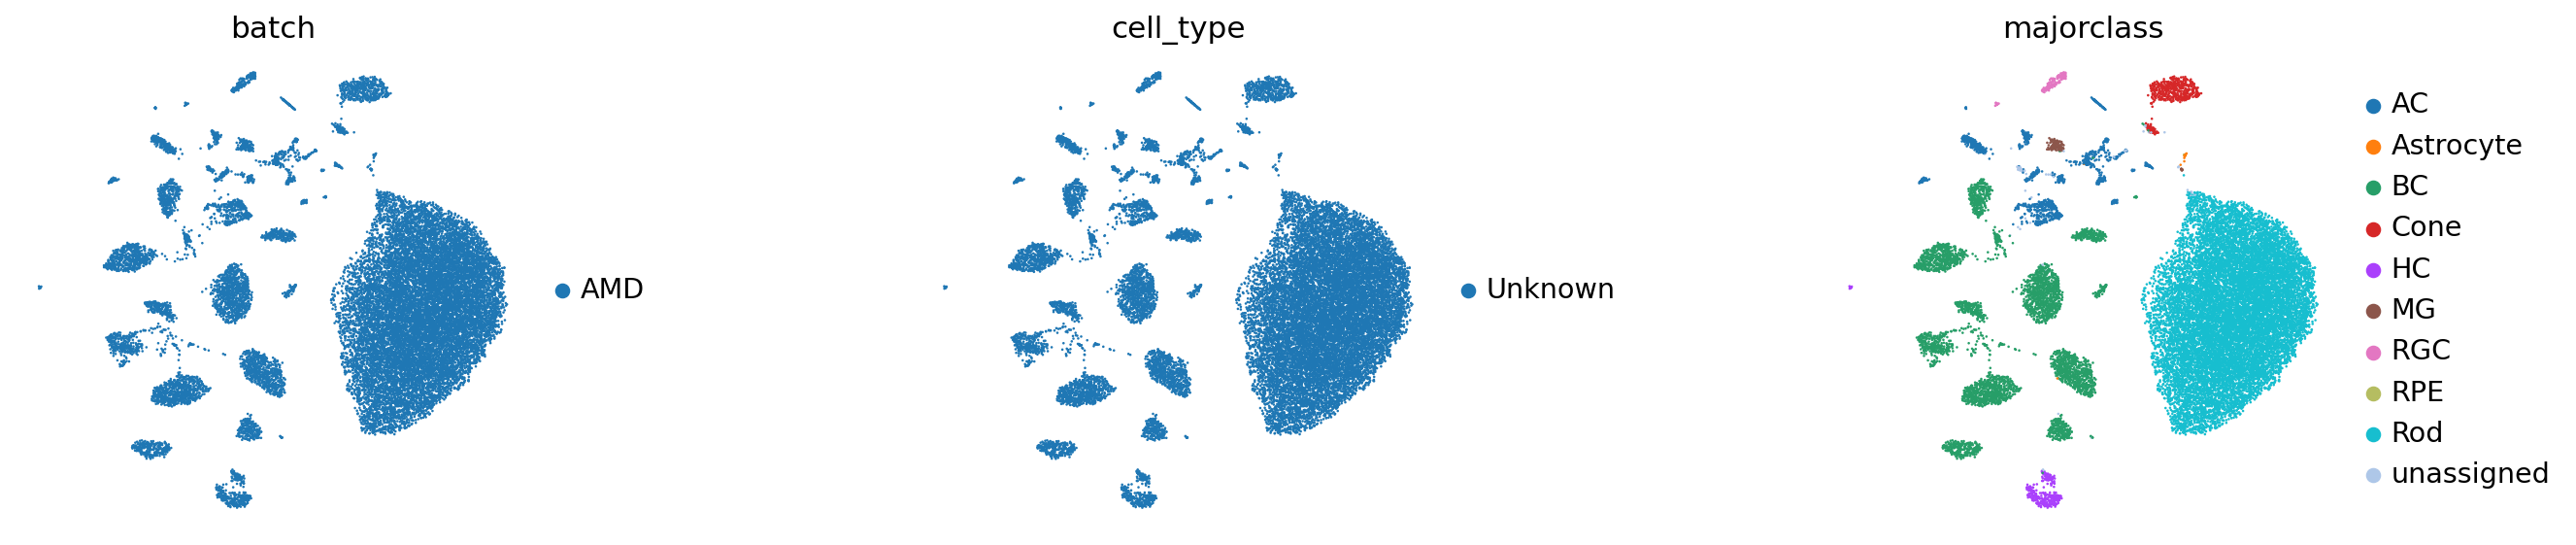

In [198]:
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type", 'majorclass'],
    frameon=False,
    wspace=0.6,
)

In [199]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)

### Compute Accuracy of model classifier for query dataset and compare predicted and observed cell types

In [200]:
query_latent.obs['predictions'] = model.predict()
print("Acc: {}".format(np.mean(query_latent.obs.predictions == query_latent.obs.cell_type)))

Acc: 0.0


<Figure size 320x320 with 0 Axes>

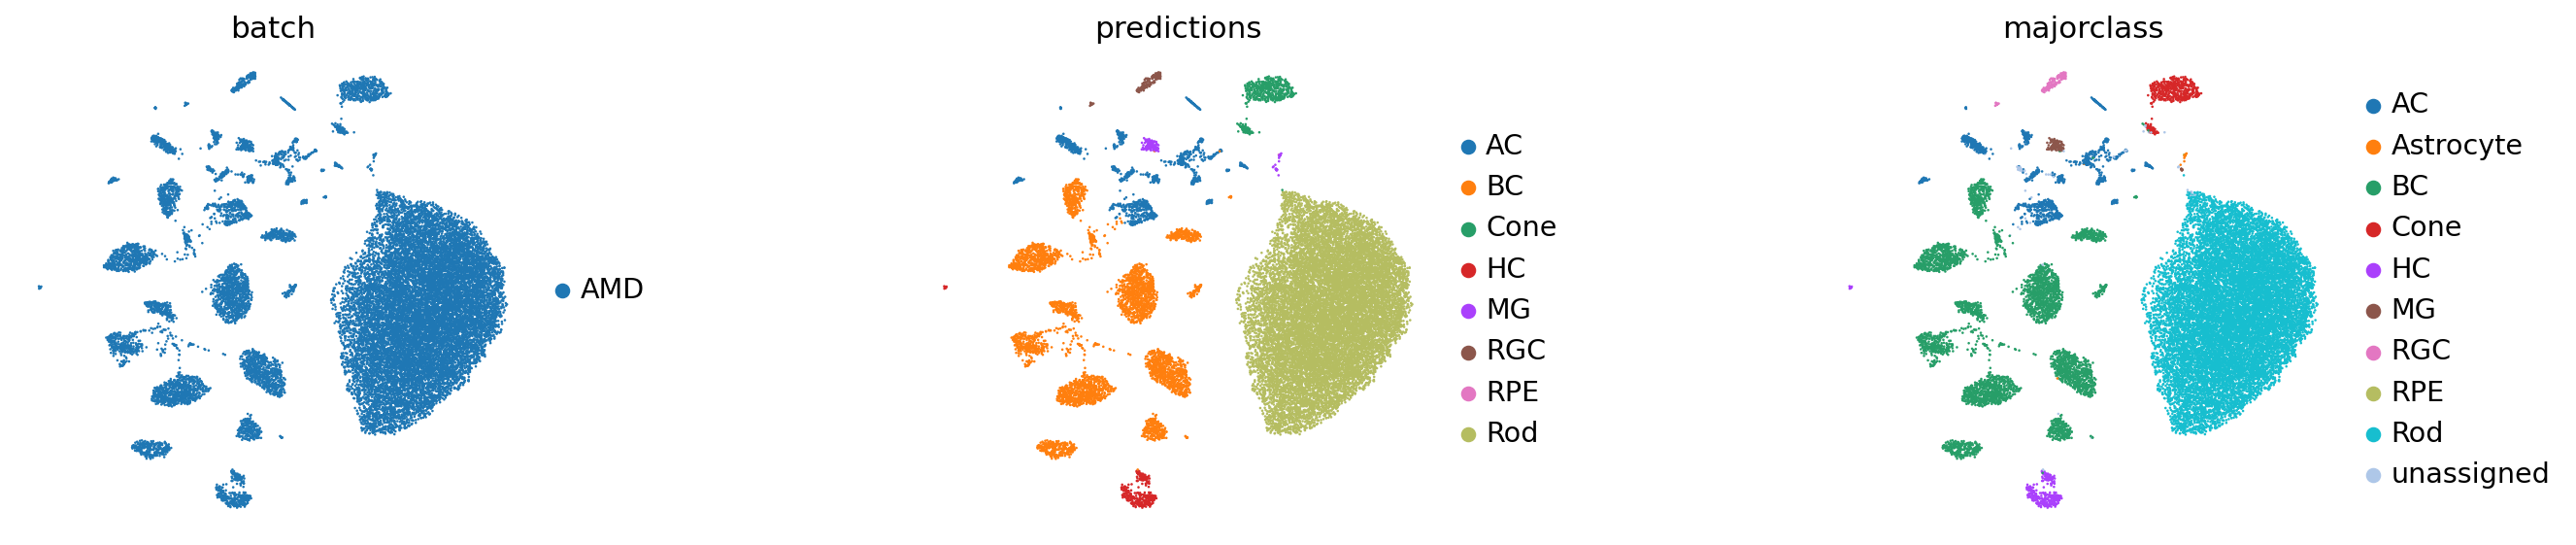

In [203]:
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "predictions", 'majorclass'],
    frameon=False,
    wspace=0.6,
)

/home/icb/ignacio.ibarra/miniconda3/envs/mapping_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


Text(0, 0.5, 'Observed')

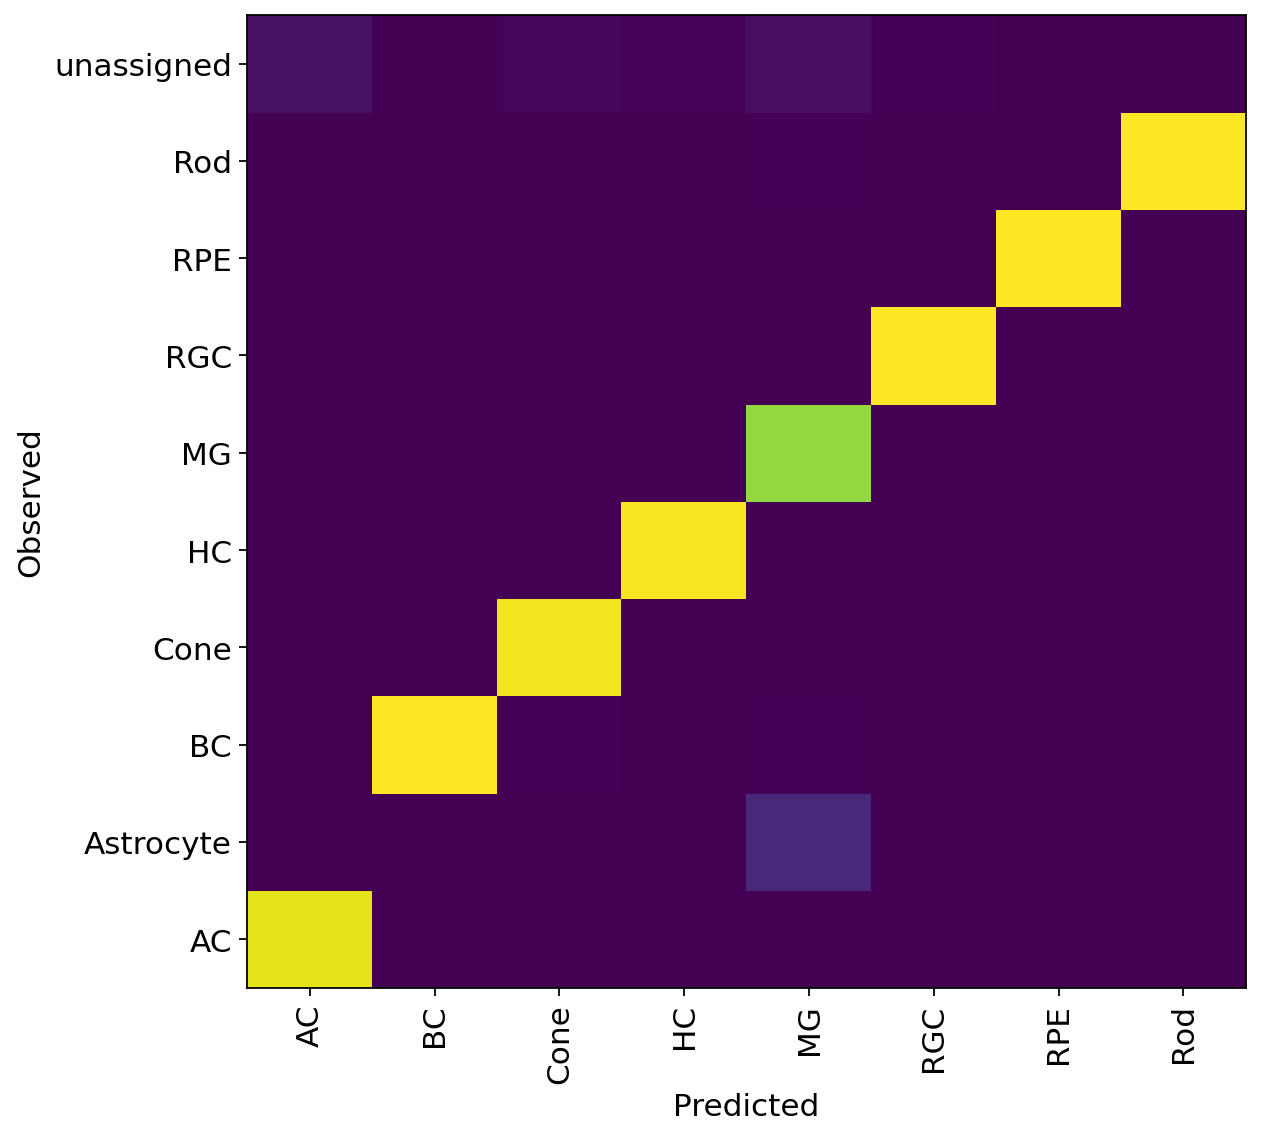

In [202]:
df = query_latent.obs.groupby(["majorclass", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

### Get latent representation of reference + query dataset and compute UMAP

In [184]:
target_adata_sub.shape

(22405, 2579)

In [178]:
adata_full = source_adata.concatenate(target_adata_sub)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


INFO:scvi.model.base._base_model:Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup


In [179]:
print('nn')
sc.pp.neighbors(full_latent)
print('leiden')
sc.tl.leiden(full_latent)
print('umap')
sc.tl.umap(full_latent)

nn
leiden
umap


In [210]:
full_latent.obs['type'] = np.where(full_latent.obs['batch'].str.contains("AMD"), 'query', 'reference')

<Figure size 320x320 with 0 Axes>

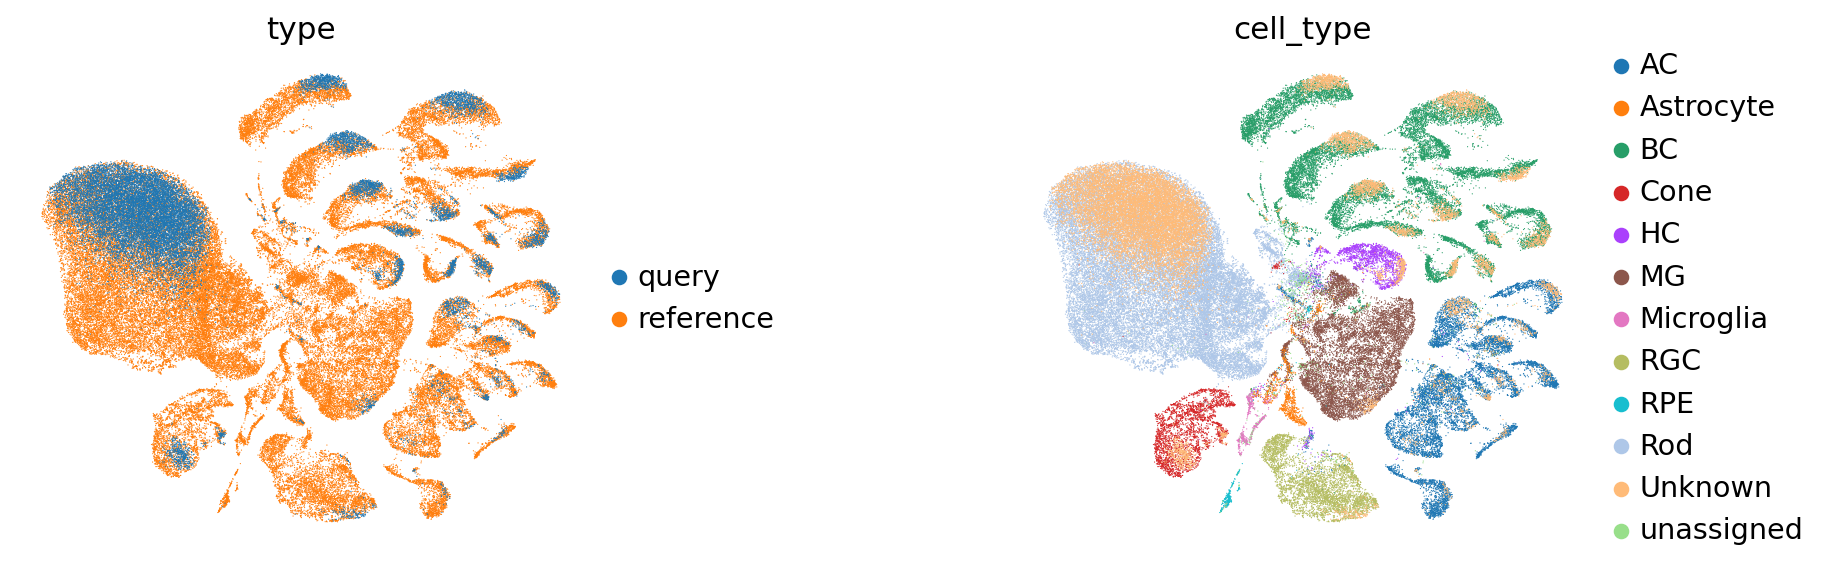

In [211]:

plt.figure()
sc.pl.umap(
    full_latent,
    color=["type", "cell_type"],
    frameon=False,
    wspace=0.6,
)

### Comparison of observed and predicted celltypes for reference + query dataset

In [212]:
full_latent.obs['predictions'] = model.predict(adata=adata_full)
print("Acc: {}".format(np.mean(full_latent.obs.predictions == full_latent.obs.cell_type)))

Acc: 0.7658422198648875


In [182]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

<Figure size 320x320 with 0 Axes>

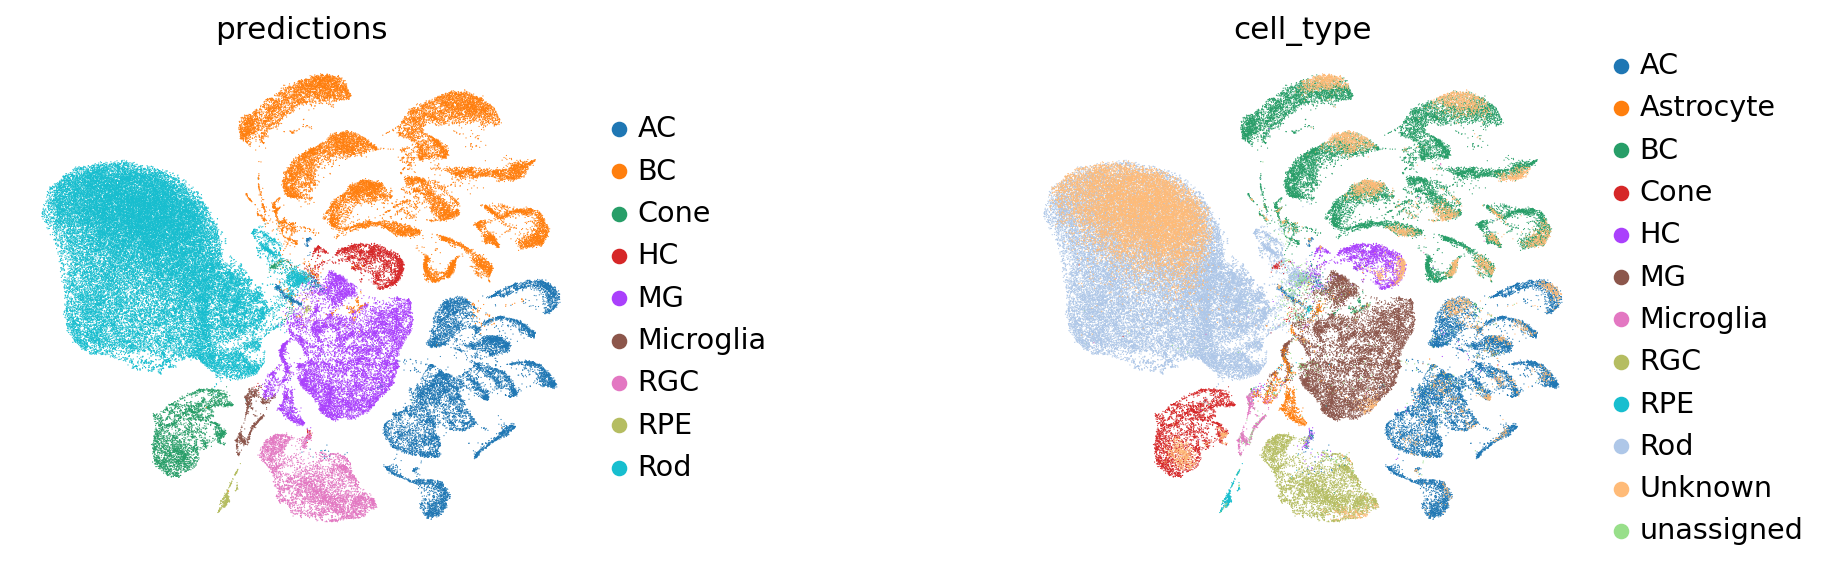

In [183]:
plt.figure()
sc.pl.umap(
    full_latent,
    color=["predictions", "cell_type"],
    frameon=False,
    wspace=0.6,
)